### IMPORT PACKAGES

In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc


Using TensorFlow backend.


In [2]:
import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config

In [3]:
def data_validating():
    if os.path.isfile(config.p_path):
        print('loading the existing data for {} model'.format(config.mode))
        with open(config.p_path,'rb') as file:
            x=pickle.load (file)
            return x
    else:
        return None

In [4]:
def process():
    temp=data_validating()
    if temp:
        return temp.data[0],temp.data[1]
    X=[]
    y=[]
    min_val, max_val= float('inf'), -float('inf')
    for _ in tqdm(range(sample)):
        classes_random= np.random.choice(distribution_of_classes.index, p=probability)
        files= np.random.choice(df[df.label == classes_random].index)
        rate,wav = wavfile.read('clean/'+files)
        label=df.at[files, 'label']
        if  (wav.shape[0]-config.step)>0:
            index_random = np.random.randint(0, wav.shape[0] - config.step)
        else:
            continue
        sample=wav[index_random:index_random+config.step]
        X_sample=mfcc(sample,rate,numcep=config.nfeat, nfilt=config.nfilt,nfft=config.nfft)
        min_val = min(np.amin(X_sample),min_val)
        max_val = max(np.amax(X_sample),max_val)
        X.append(X_sample)
        y.append(classes.index(label))
    config.min=min_val
    config.max=max_val
    X,y=np.array(X),np.array(y)
    X=(X-min_val)/(max_val - min_val)
    if config.mode == 'conv':
        X=X.reshape(X.shape[0], X.shape[1],X.shape[2], 1)
    elif config.mode == 'time':
        X=X.reshape(X.shape[0], X.shape[1], X.shape[2])
    y=to_categorical(y, num_classes=10)
    config.data=(X,y)
    
    
    with open(config.p_path,'wb') as file:
        file.dump(config, handle,protocol=2)
    
    return X, y
                    

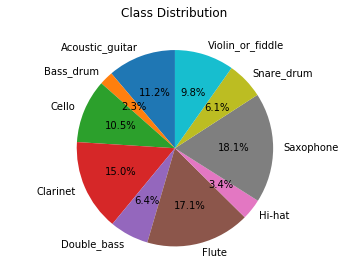

In [5]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for i in df.index:
    rate, signal = wavfile.read('clean/'+i)
    df.at[i, 'length'] = signal.shape[0]/rate

list_classes = list(np.unique(df.label))
distribution_of_classes = df.groupby(['label'])['length'].mean()

sample= 2* int(df['length'].sum()/0.1)
probability = distribution_of_classes / distribution_of_classes.sum()
choices = np.random.choice(distribution_of_classes.index, p= probability)

figure, axis = plt.subplots()
axis.set_title('Class Distribution', y=1.08)
axis.pie(distribution_of_classes, labels=distribution_of_classes.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
axis.axis('equal')
plt.show()


### Convolutional Neural Network

In [6]:
def cnn_model():
    model=Sequential()
    model.add(Conv2D(16,(3,3), activation='relu',strides=(1,1),padding='same',input_shape=input_data))
    model.add(Conv2D(32,(3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(64,(3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(Conv2D(128,(3,3), activation='relu',strides=(1,1),padding='same'))
    model.add(MaxPool2D((2,2))) 
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu')) 
    model.add(Dense(64,activation='relu'))  
    model.add(Dense(10,activation='softmax')) 
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    
    return model


In [7]:
config=Config(mode='conv')
print(config.mode)

conv


In [8]:
if config.mode == 'conv' :
    X,y=process()
    y_index_max=np.argmax(y,axis=1)
    input_data=(X.shape[1], X.shape[2], 1)
    model=cnn_model()

elif config.mode== 'time':
    X,y= process()
    y_index_max=np.argmax(y,axis=1)
    input_data=(X.shape[1], X.shape[2])
    model=rnn_model()





loading the existing data for conv model





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 9, 16)         160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 9, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 9, 64)         18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 9, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 4, 128) 

In [9]:
    
class_weight= compute_class_weight('balanced',np.unique(y_index_max),y_index_max)

checkpoint=ModelCheckpoint(config.model_path,monitor='val_acc',verbose=1,mode='max',save_best_only=True,save_weights_only=False,period=1)
cnn_model=model.fit(X,y,epochs=10,batch_size=32,shuffle=True,validation_split=0.1,callbacks=[checkpoint])

model.save(config.model_path)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 19628 samples, validate on 2181 samples
Epoch 1/10







18080/19628 [==========================>...] - ETA: 9:11 - loss: 2.3006 - acc: 0.062 - ETA: 3:19 - loss: 2.2628 - acc: 0.093 - ETA: 2:07 - loss: 2.2549 - acc: 0.118 - ETA: 1:36 - loss: 2.2456 - acc: 0.138 - ETA: 1:18 - loss: 2.2279 - acc: 0.142 - ETA: 1:02 - loss: 2.2215 - acc: 0.153 - ETA: 55s - loss: 2.2099 - acc: 0.162 - ETA: 48s - loss: 2.1958 - acc: 0.17 - ETA: 42s - loss: 2.1881 - acc: 0.17 - ETA: 39s - loss: 2.1844 - acc: 0.17 - ETA: 37s - loss: 2.1882 - acc: 0.17 - ETA: 35s - loss: 2.1903 - acc: 0.17 - ETA: 34s - loss: 2.1874 - acc: 0.17 - ETA: 32s - loss: 2.1868 - acc: 0.17 - ETA: 30s - loss: 2.1882 - acc: 0.16 - ETA: 28s - loss: 2.1851 - acc: 0.16 - ETA: 27s - loss: 2.1782 - acc: 0.16 - ETA: 26s - loss: 2.1668 - acc: 0.16 - ETA: 25s - loss: 2.1617 - acc: 0.16 - ETA: 24s - loss: 2.1501 - acc: 0.17 - ETA: 23s - loss: 2.1379 - acc: 0.17 - ETA: 23s - loss: 2.1266 - acc: 0.18 - ETA: 22s - loss: 2.1066 - acc: 0.18 - ETA: 22s - loss: 2.0889 - acc: 0.19 - ETA: 21s - loss: 2.0866 - ac

19628/19628 [==============================] - ETA: 1s - loss: 1.0562 - acc: 0.619 - ETA: 1s - loss: 1.0536 - acc: 0.619 - ETA: 1s - loss: 1.0516 - acc: 0.620 - ETA: 0s - loss: 1.0487 - acc: 0.621 - ETA: 0s - loss: 1.0461 - acc: 0.622 - ETA: 0s - loss: 1.0429 - acc: 0.623 - ETA: 0s - loss: 1.0406 - acc: 0.624 - ETA: 0s - loss: 1.0378 - acc: 0.625 - ETA: 0s - loss: 1.0359 - acc: 0.626 - ETA: 0s - loss: 1.0343 - acc: 0.627 - ETA: 0s - loss: 1.0324 - acc: 0.627 - ETA: 0s - loss: 1.0299 - acc: 0.628 - ETA: 0s - loss: 1.0279 - acc: 0.629 - ETA: 0s - loss: 1.0263 - acc: 0.630 - ETA: 0s - loss: 1.0236 - acc: 0.631 - ETA: 0s - loss: 1.0221 - acc: 0.631 - ETA: 0s - loss: 1.0203 - acc: 0.632 - 16s 830us/step - loss: 1.0201 - acc: 0.6324 - val_loss: 0.4381 - val_acc: 0.8565

Epoch 00001: val_acc improved from -inf to 0.85649, saving model to models\conv.model
Epoch 2/10


18400/19628 [===========================>..] - ETA: 13s - loss: 0.8616 - acc: 0.68 - ETA: 14s - loss: 0.7266 - acc: 0.71 - ETA: 14s - loss: 0.6368 - acc: 0.76 - ETA: 14s - loss: 0.6574 - acc: 0.76 - ETA: 14s - loss: 0.6203 - acc: 0.79 - ETA: 13s - loss: 0.5891 - acc: 0.79 - ETA: 13s - loss: 0.5778 - acc: 0.79 - ETA: 13s - loss: 0.5859 - acc: 0.78 - ETA: 13s - loss: 0.5946 - acc: 0.78 - ETA: 13s - loss: 0.5955 - acc: 0.78 - ETA: 13s - loss: 0.5980 - acc: 0.78 - ETA: 13s - loss: 0.5988 - acc: 0.78 - ETA: 13s - loss: 0.5919 - acc: 0.79 - ETA: 13s - loss: 0.5822 - acc: 0.79 - ETA: 13s - loss: 0.5788 - acc: 0.79 - ETA: 13s - loss: 0.5837 - acc: 0.79 - ETA: 13s - loss: 0.5764 - acc: 0.80 - ETA: 13s - loss: 0.5636 - acc: 0.80 - ETA: 13s - loss: 0.5586 - acc: 0.80 - ETA: 13s - loss: 0.5526 - acc: 0.80 - ETA: 13s - loss: 0.5555 - acc: 0.80 - ETA: 13s - loss: 0.5556 - acc: 0.80 - ETA: 12s - loss: 0.5526 - acc: 0.80 - ETA: 12s - loss: 0.5586 - acc: 0.80 - ETA: 12s - loss: 0.5583 - acc: 0.80 - ETA

19628/19628 [==============================] - ETA: 0s - loss: 0.4315 - acc: 0.850 - ETA: 0s - loss: 0.4304 - acc: 0.851 - ETA: 0s - loss: 0.4306 - acc: 0.851 - ETA: 0s - loss: 0.4298 - acc: 0.851 - ETA: 0s - loss: 0.4296 - acc: 0.851 - ETA: 0s - loss: 0.4297 - acc: 0.851 - ETA: 0s - loss: 0.4294 - acc: 0.851 - ETA: 0s - loss: 0.4290 - acc: 0.851 - ETA: 0s - loss: 0.4284 - acc: 0.851 - ETA: 0s - loss: 0.4283 - acc: 0.851 - ETA: 0s - loss: 0.4282 - acc: 0.852 - ETA: 0s - loss: 0.4275 - acc: 0.852 - ETA: 0s - loss: 0.4272 - acc: 0.852 - 15s 776us/step - loss: 0.4269 - acc: 0.8524 - val_loss: 0.2764 - val_acc: 0.9078

Epoch 00002: val_acc improved from 0.85649 to 0.90784, saving model to models\conv.model
Epoch 3/10


18592/19628 [===========================>..] - ETA: 16s - loss: 0.1973 - acc: 0.93 - ETA: 16s - loss: 0.3006 - acc: 0.89 - ETA: 14s - loss: 0.3358 - acc: 0.89 - ETA: 15s - loss: 0.3154 - acc: 0.90 - ETA: 14s - loss: 0.3245 - acc: 0.89 - ETA: 14s - loss: 0.3185 - acc: 0.89 - ETA: 14s - loss: 0.3245 - acc: 0.88 - ETA: 14s - loss: 0.3274 - acc: 0.88 - ETA: 14s - loss: 0.3098 - acc: 0.89 - ETA: 13s - loss: 0.3143 - acc: 0.89 - ETA: 13s - loss: 0.3097 - acc: 0.89 - ETA: 13s - loss: 0.3141 - acc: 0.89 - ETA: 13s - loss: 0.3140 - acc: 0.89 - ETA: 13s - loss: 0.3148 - acc: 0.89 - ETA: 13s - loss: 0.3116 - acc: 0.89 - ETA: 13s - loss: 0.3089 - acc: 0.89 - ETA: 13s - loss: 0.3108 - acc: 0.89 - ETA: 13s - loss: 0.3057 - acc: 0.89 - ETA: 13s - loss: 0.2979 - acc: 0.89 - ETA: 13s - loss: 0.2973 - acc: 0.89 - ETA: 13s - loss: 0.3033 - acc: 0.89 - ETA: 13s - loss: 0.3003 - acc: 0.89 - ETA: 12s - loss: 0.3013 - acc: 0.89 - ETA: 12s - loss: 0.3020 - acc: 0.89 - ETA: 12s - loss: 0.2984 - acc: 0.90 - ETA

19628/19628 [==============================] - ETA: 0s - loss: 0.2734 - acc: 0.904 - ETA: 0s - loss: 0.2731 - acc: 0.904 - ETA: 0s - loss: 0.2732 - acc: 0.904 - ETA: 0s - loss: 0.2729 - acc: 0.904 - ETA: 0s - loss: 0.2728 - acc: 0.904 - ETA: 0s - loss: 0.2728 - acc: 0.904 - ETA: 0s - loss: 0.2727 - acc: 0.904 - ETA: 0s - loss: 0.2724 - acc: 0.904 - ETA: 0s - loss: 0.2725 - acc: 0.904 - ETA: 0s - loss: 0.2726 - acc: 0.904 - ETA: 0s - loss: 0.2724 - acc: 0.904 - ETA: 0s - loss: 0.2723 - acc: 0.904 - 15s 780us/step - loss: 0.2721 - acc: 0.9048 - val_loss: 0.1696 - val_acc: 0.9427

Epoch 00003: val_acc improved from 0.90784 to 0.94269, saving model to models\conv.model
Epoch 4/10


15840/19628 [=======================>......] - ETA: 21s - loss: 0.2036 - acc: 0.90 - ETA: 18s - loss: 0.2060 - acc: 0.92 - ETA: 17s - loss: 0.2565 - acc: 0.90 - ETA: 16s - loss: 0.2357 - acc: 0.91 - ETA: 16s - loss: 0.2523 - acc: 0.90 - ETA: 15s - loss: 0.2449 - acc: 0.90 - ETA: 15s - loss: 0.2149 - acc: 0.91 - ETA: 15s - loss: 0.2306 - acc: 0.91 - ETA: 15s - loss: 0.2246 - acc: 0.91 - ETA: 15s - loss: 0.2175 - acc: 0.91 - ETA: 15s - loss: 0.2236 - acc: 0.91 - ETA: 15s - loss: 0.2247 - acc: 0.91 - ETA: 14s - loss: 0.2158 - acc: 0.91 - ETA: 14s - loss: 0.2138 - acc: 0.91 - ETA: 14s - loss: 0.2124 - acc: 0.91 - ETA: 14s - loss: 0.2139 - acc: 0.91 - ETA: 14s - loss: 0.2137 - acc: 0.91 - ETA: 14s - loss: 0.2122 - acc: 0.91 - ETA: 14s - loss: 0.2105 - acc: 0.92 - ETA: 14s - loss: 0.2154 - acc: 0.92 - ETA: 15s - loss: 0.2129 - acc: 0.92 - ETA: 15s - loss: 0.2115 - acc: 0.92 - ETA: 15s - loss: 0.2085 - acc: 0.92 - ETA: 15s - loss: 0.2136 - acc: 0.91 - ETA: 15s - loss: 0.2208 - acc: 0.91 - ETA

19628/19628 [==============================] - ETA: 3s - loss: 0.2214 - acc: 0.922 - ETA: 3s - loss: 0.2212 - acc: 0.922 - ETA: 3s - loss: 0.2216 - acc: 0.922 - ETA: 3s - loss: 0.2218 - acc: 0.922 - ETA: 3s - loss: 0.2217 - acc: 0.922 - ETA: 3s - loss: 0.2214 - acc: 0.922 - ETA: 2s - loss: 0.2208 - acc: 0.922 - ETA: 2s - loss: 0.2207 - acc: 0.922 - ETA: 2s - loss: 0.2202 - acc: 0.923 - ETA: 2s - loss: 0.2209 - acc: 0.922 - ETA: 2s - loss: 0.2202 - acc: 0.923 - ETA: 2s - loss: 0.2201 - acc: 0.923 - ETA: 2s - loss: 0.2206 - acc: 0.922 - ETA: 2s - loss: 0.2202 - acc: 0.922 - ETA: 2s - loss: 0.2204 - acc: 0.922 - ETA: 2s - loss: 0.2204 - acc: 0.922 - ETA: 2s - loss: 0.2204 - acc: 0.923 - ETA: 2s - loss: 0.2205 - acc: 0.922 - ETA: 2s - loss: 0.2207 - acc: 0.922 - ETA: 2s - loss: 0.2204 - acc: 0.923 - ETA: 1s - loss: 0.2202 - acc: 0.923 - ETA: 1s - loss: 0.2198 - acc: 0.923 - ETA: 1s - loss: 0.2197 - acc: 0.923 - ETA: 1s - loss: 0.2194 - acc: 0.923 - ETA: 1s - loss: 0.2195 - acc: 0.923 - ETA

18880/19628 [===========================>..] - ETA: 16s - loss: 0.1494 - acc: 0.96 - ETA: 16s - loss: 0.1337 - acc: 0.94 - ETA: 14s - loss: 0.1343 - acc: 0.95 - ETA: 14s - loss: 0.1918 - acc: 0.93 - ETA: 14s - loss: 0.1755 - acc: 0.93 - ETA: 14s - loss: 0.2079 - acc: 0.92 - ETA: 14s - loss: 0.2130 - acc: 0.92 - ETA: 14s - loss: 0.2039 - acc: 0.92 - ETA: 14s - loss: 0.1880 - acc: 0.93 - ETA: 13s - loss: 0.1914 - acc: 0.93 - ETA: 13s - loss: 0.1930 - acc: 0.93 - ETA: 13s - loss: 0.1915 - acc: 0.93 - ETA: 13s - loss: 0.1897 - acc: 0.93 - ETA: 13s - loss: 0.1849 - acc: 0.93 - ETA: 13s - loss: 0.1781 - acc: 0.93 - ETA: 13s - loss: 0.1841 - acc: 0.93 - ETA: 13s - loss: 0.1890 - acc: 0.93 - ETA: 13s - loss: 0.1924 - acc: 0.93 - ETA: 13s - loss: 0.2005 - acc: 0.92 - ETA: 13s - loss: 0.2036 - acc: 0.92 - ETA: 13s - loss: 0.2153 - acc: 0.92 - ETA: 12s - loss: 0.2203 - acc: 0.92 - ETA: 12s - loss: 0.2202 - acc: 0.92 - ETA: 12s - loss: 0.2226 - acc: 0.92 - ETA: 12s - loss: 0.2229 - acc: 0.92 - ETA

19628/19628 [==============================] - ETA: 0s - loss: 0.1817 - acc: 0.938 - ETA: 0s - loss: 0.1815 - acc: 0.938 - ETA: 0s - loss: 0.1814 - acc: 0.938 - ETA: 0s - loss: 0.1812 - acc: 0.938 - ETA: 0s - loss: 0.1810 - acc: 0.938 - ETA: 0s - loss: 0.1812 - acc: 0.938 - ETA: 0s - loss: 0.1813 - acc: 0.938 - ETA: 0s - loss: 0.1810 - acc: 0.938 - ETA: 0s - loss: 0.1807 - acc: 0.938 - ETA: 0s - loss: 0.1807 - acc: 0.938 - ETA: 0s - loss: 0.1808 - acc: 0.938 - ETA: 0s - loss: 0.1807 - acc: 0.938 - ETA: 0s - loss: 0.1806 - acc: 0.938 - 16s 792us/step - loss: 0.1805 - acc: 0.9387 - val_loss: 0.1414 - val_acc: 0.9514

Epoch 00005: val_acc improved from 0.95094 to 0.95140, saving model to models\conv.model
Epoch 6/10


18592/19628 [===========================>..] - ETA: 14s - loss: 0.1977 - acc: 0.87 - ETA: 14s - loss: 0.1557 - acc: 0.94 - ETA: 14s - loss: 0.1275 - acc: 0.95 - ETA: 15s - loss: 0.1350 - acc: 0.93 - ETA: 15s - loss: 0.1415 - acc: 0.94 - ETA: 14s - loss: 0.1320 - acc: 0.94 - ETA: 14s - loss: 0.1409 - acc: 0.94 - ETA: 14s - loss: 0.1418 - acc: 0.94 - ETA: 14s - loss: 0.1534 - acc: 0.94 - ETA: 14s - loss: 0.1621 - acc: 0.94 - ETA: 14s - loss: 0.1516 - acc: 0.94 - ETA: 14s - loss: 0.1545 - acc: 0.94 - ETA: 14s - loss: 0.1572 - acc: 0.94 - ETA: 13s - loss: 0.1585 - acc: 0.94 - ETA: 13s - loss: 0.1621 - acc: 0.94 - ETA: 13s - loss: 0.1647 - acc: 0.94 - ETA: 13s - loss: 0.1583 - acc: 0.94 - ETA: 13s - loss: 0.1585 - acc: 0.94 - ETA: 13s - loss: 0.1542 - acc: 0.94 - ETA: 13s - loss: 0.1555 - acc: 0.94 - ETA: 13s - loss: 0.1570 - acc: 0.94 - ETA: 13s - loss: 0.1601 - acc: 0.94 - ETA: 13s - loss: 0.1665 - acc: 0.94 - ETA: 13s - loss: 0.1658 - acc: 0.94 - ETA: 13s - loss: 0.1621 - acc: 0.94 - ETA

19628/19628 [==============================] - ETA: 0s - loss: 0.1451 - acc: 0.948 - ETA: 0s - loss: 0.1449 - acc: 0.948 - ETA: 0s - loss: 0.1447 - acc: 0.948 - ETA: 0s - loss: 0.1445 - acc: 0.948 - ETA: 0s - loss: 0.1446 - acc: 0.948 - ETA: 0s - loss: 0.1442 - acc: 0.948 - ETA: 0s - loss: 0.1441 - acc: 0.948 - ETA: 0s - loss: 0.1437 - acc: 0.948 - ETA: 0s - loss: 0.1434 - acc: 0.948 - ETA: 0s - loss: 0.1432 - acc: 0.948 - ETA: 0s - loss: 0.1438 - acc: 0.948 - ETA: 0s - loss: 0.1436 - acc: 0.948 - 15s 782us/step - loss: 0.1435 - acc: 0.9488 - val_loss: 0.1066 - val_acc: 0.9674

Epoch 00006: val_acc improved from 0.95140 to 0.96745, saving model to models\conv.model
Epoch 7/10


17152/19628 [=========================>....] - ETA: 14s - loss: 0.0478 - acc: 1.00 - ETA: 13s - loss: 0.1448 - acc: 0.95 - ETA: 16s - loss: 0.1291 - acc: 0.95 - ETA: 16s - loss: 0.1564 - acc: 0.93 - ETA: 16s - loss: 0.1594 - acc: 0.94 - ETA: 15s - loss: 0.1604 - acc: 0.93 - ETA: 15s - loss: 0.1455 - acc: 0.93 - ETA: 14s - loss: 0.1454 - acc: 0.94 - ETA: 14s - loss: 0.1514 - acc: 0.94 - ETA: 14s - loss: 0.1445 - acc: 0.94 - ETA: 14s - loss: 0.1436 - acc: 0.94 - ETA: 14s - loss: 0.1411 - acc: 0.94 - ETA: 14s - loss: 0.1454 - acc: 0.94 - ETA: 14s - loss: 0.1552 - acc: 0.94 - ETA: 14s - loss: 0.1536 - acc: 0.94 - ETA: 14s - loss: 0.1476 - acc: 0.94 - ETA: 14s - loss: 0.1496 - acc: 0.94 - ETA: 14s - loss: 0.1464 - acc: 0.94 - ETA: 14s - loss: 0.1421 - acc: 0.94 - ETA: 14s - loss: 0.1389 - acc: 0.94 - ETA: 14s - loss: 0.1393 - acc: 0.94 - ETA: 14s - loss: 0.1356 - acc: 0.95 - ETA: 14s - loss: 0.1372 - acc: 0.95 - ETA: 14s - loss: 0.1359 - acc: 0.95 - ETA: 14s - loss: 0.1379 - acc: 0.94 - ETA

19628/19628 [==============================] - ETA: 1s - loss: 0.1332 - acc: 0.954 - ETA: 1s - loss: 0.1330 - acc: 0.954 - ETA: 1s - loss: 0.1331 - acc: 0.954 - ETA: 1s - loss: 0.1327 - acc: 0.954 - ETA: 1s - loss: 0.1327 - acc: 0.954 - ETA: 1s - loss: 0.1327 - acc: 0.954 - ETA: 1s - loss: 0.1329 - acc: 0.954 - ETA: 1s - loss: 0.1326 - acc: 0.954 - ETA: 1s - loss: 0.1323 - acc: 0.954 - ETA: 1s - loss: 0.1323 - acc: 0.954 - ETA: 1s - loss: 0.1321 - acc: 0.954 - ETA: 1s - loss: 0.1324 - acc: 0.954 - ETA: 1s - loss: 0.1325 - acc: 0.954 - ETA: 1s - loss: 0.1321 - acc: 0.954 - ETA: 0s - loss: 0.1319 - acc: 0.954 - ETA: 0s - loss: 0.1319 - acc: 0.954 - ETA: 0s - loss: 0.1316 - acc: 0.954 - ETA: 0s - loss: 0.1315 - acc: 0.954 - ETA: 0s - loss: 0.1312 - acc: 0.954 - ETA: 0s - loss: 0.1310 - acc: 0.954 - ETA: 0s - loss: 0.1312 - acc: 0.954 - ETA: 0s - loss: 0.1311 - acc: 0.954 - ETA: 0s - loss: 0.1309 - acc: 0.954 - ETA: 0s - loss: 0.1309 - acc: 0.954 - ETA: 0s - loss: 0.1306 - acc: 0.955 - ETA

18592/19628 [===========================>..] - ETA: 15s - loss: 0.5553 - acc: 0.93 - ETA: 14s - loss: 0.1756 - acc: 0.97 - ETA: 14s - loss: 0.1551 - acc: 0.96 - ETA: 14s - loss: 0.1427 - acc: 0.96 - ETA: 13s - loss: 0.1497 - acc: 0.95 - ETA: 13s - loss: 0.1325 - acc: 0.96 - ETA: 14s - loss: 0.1361 - acc: 0.96 - ETA: 13s - loss: 0.1295 - acc: 0.96 - ETA: 14s - loss: 0.1278 - acc: 0.96 - ETA: 13s - loss: 0.1270 - acc: 0.96 - ETA: 13s - loss: 0.1221 - acc: 0.96 - ETA: 13s - loss: 0.1233 - acc: 0.96 - ETA: 13s - loss: 0.1242 - acc: 0.95 - ETA: 13s - loss: 0.1261 - acc: 0.95 - ETA: 13s - loss: 0.1249 - acc: 0.95 - ETA: 13s - loss: 0.1232 - acc: 0.95 - ETA: 13s - loss: 0.1264 - acc: 0.95 - ETA: 13s - loss: 0.1259 - acc: 0.95 - ETA: 13s - loss: 0.1269 - acc: 0.95 - ETA: 13s - loss: 0.1258 - acc: 0.95 - ETA: 13s - loss: 0.1218 - acc: 0.95 - ETA: 13s - loss: 0.1199 - acc: 0.95 - ETA: 13s - loss: 0.1200 - acc: 0.95 - ETA: 12s - loss: 0.1152 - acc: 0.96 - ETA: 12s - loss: 0.1150 - acc: 0.96 - ETA

19628/19628 [==============================] - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1090 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1090 - acc: 0.962 - ETA: 0s - loss: 0.1092 - acc: 0.962 - ETA: 0s - loss: 0.1092 - acc: 0.962 - ETA: 0s - loss: 0.1093 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1089 - acc: 0.962 - ETA: 0s - loss: 0.1089 - acc: 0.962 - 15s 780us/step - loss: 0.1087 - acc: 0.9624 - val_loss: 0.0766 - val_acc: 0.9757

Epoch 00008: val_acc improved from 0.96836 to 0.97570, saving model to models\conv.model
Epoch 9/10


17376/19628 [=========================>....] - ETA: 12s - loss: 0.0182 - acc: 1.00 - ETA: 12s - loss: 0.0471 - acc: 0.98 - ETA: 13s - loss: 0.0569 - acc: 0.98 - ETA: 13s - loss: 0.0628 - acc: 0.97 - ETA: 13s - loss: 0.0673 - acc: 0.97 - ETA: 14s - loss: 0.0562 - acc: 0.98 - ETA: 14s - loss: 0.0621 - acc: 0.97 - ETA: 14s - loss: 0.0600 - acc: 0.98 - ETA: 14s - loss: 0.0580 - acc: 0.98 - ETA: 14s - loss: 0.0594 - acc: 0.98 - ETA: 13s - loss: 0.0585 - acc: 0.98 - ETA: 13s - loss: 0.0584 - acc: 0.98 - ETA: 13s - loss: 0.0555 - acc: 0.98 - ETA: 13s - loss: 0.0622 - acc: 0.98 - ETA: 13s - loss: 0.0661 - acc: 0.98 - ETA: 13s - loss: 0.0721 - acc: 0.97 - ETA: 13s - loss: 0.0714 - acc: 0.97 - ETA: 13s - loss: 0.0707 - acc: 0.97 - ETA: 13s - loss: 0.0750 - acc: 0.97 - ETA: 13s - loss: 0.0738 - acc: 0.97 - ETA: 13s - loss: 0.0721 - acc: 0.97 - ETA: 13s - loss: 0.0747 - acc: 0.97 - ETA: 13s - loss: 0.0745 - acc: 0.97 - ETA: 12s - loss: 0.0773 - acc: 0.97 - ETA: 12s - loss: 0.0785 - acc: 0.97 - ETA

19628/19628 [==============================] - ETA: 1s - loss: 0.1108 - acc: 0.962 - ETA: 1s - loss: 0.1106 - acc: 0.962 - ETA: 1s - loss: 0.1105 - acc: 0.962 - ETA: 1s - loss: 0.1103 - acc: 0.962 - ETA: 1s - loss: 0.1101 - acc: 0.962 - ETA: 1s - loss: 0.1101 - acc: 0.962 - ETA: 1s - loss: 0.1096 - acc: 0.962 - ETA: 1s - loss: 0.1103 - acc: 0.962 - ETA: 1s - loss: 0.1101 - acc: 0.962 - ETA: 1s - loss: 0.1098 - acc: 0.962 - ETA: 1s - loss: 0.1096 - acc: 0.962 - ETA: 1s - loss: 0.1095 - acc: 0.962 - ETA: 0s - loss: 0.1093 - acc: 0.962 - ETA: 0s - loss: 0.1094 - acc: 0.962 - ETA: 0s - loss: 0.1092 - acc: 0.962 - ETA: 0s - loss: 0.1095 - acc: 0.962 - ETA: 0s - loss: 0.1093 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1092 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1090 - acc: 0.962 - ETA: 0s - loss: 0.1091 - acc: 0.962 - ETA: 0s - loss: 0.1090 - acc: 0.962 - ETA: 0s - loss: 0.1089 - acc: 0.962 - ETA: 0s - loss: 0.1090 - acc: 0.962 - ETA

17504/19628 [=========================>....] - ETA: 14s - loss: 0.1915 - acc: 0.87 - ETA: 15s - loss: 0.1338 - acc: 0.93 - ETA: 17s - loss: 0.0984 - acc: 0.96 - ETA: 15s - loss: 0.1170 - acc: 0.95 - ETA: 16s - loss: 0.1232 - acc: 0.95 - ETA: 15s - loss: 0.1208 - acc: 0.95 - ETA: 15s - loss: 0.1132 - acc: 0.95 - ETA: 15s - loss: 0.1169 - acc: 0.95 - ETA: 15s - loss: 0.1156 - acc: 0.95 - ETA: 15s - loss: 0.1204 - acc: 0.95 - ETA: 15s - loss: 0.1167 - acc: 0.95 - ETA: 15s - loss: 0.1264 - acc: 0.95 - ETA: 15s - loss: 0.1277 - acc: 0.95 - ETA: 15s - loss: 0.1228 - acc: 0.95 - ETA: 15s - loss: 0.1245 - acc: 0.95 - ETA: 15s - loss: 0.1228 - acc: 0.95 - ETA: 15s - loss: 0.1202 - acc: 0.95 - ETA: 15s - loss: 0.1189 - acc: 0.95 - ETA: 15s - loss: 0.1148 - acc: 0.95 - ETA: 15s - loss: 0.1126 - acc: 0.95 - ETA: 15s - loss: 0.1121 - acc: 0.95 - ETA: 15s - loss: 0.1124 - acc: 0.95 - ETA: 15s - loss: 0.1087 - acc: 0.95 - ETA: 15s - loss: 0.1078 - acc: 0.96 - ETA: 14s - loss: 0.1051 - acc: 0.96 - ETA

19628/19628 [==============================] - ETA: 1s - loss: 0.0953 - acc: 0.965 - ETA: 1s - loss: 0.0955 - acc: 0.965 - ETA: 1s - loss: 0.0956 - acc: 0.965 - ETA: 1s - loss: 0.0956 - acc: 0.965 - ETA: 1s - loss: 0.0956 - acc: 0.965 - ETA: 1s - loss: 0.0953 - acc: 0.966 - ETA: 1s - loss: 0.0953 - acc: 0.965 - ETA: 1s - loss: 0.0952 - acc: 0.965 - ETA: 1s - loss: 0.0952 - acc: 0.965 - ETA: 1s - loss: 0.0950 - acc: 0.965 - ETA: 1s - loss: 0.0955 - acc: 0.965 - ETA: 0s - loss: 0.0957 - acc: 0.965 - ETA: 0s - loss: 0.0957 - acc: 0.965 - ETA: 0s - loss: 0.0956 - acc: 0.965 - ETA: 0s - loss: 0.0955 - acc: 0.965 - ETA: 0s - loss: 0.0953 - acc: 0.965 - ETA: 0s - loss: 0.0952 - acc: 0.965 - ETA: 0s - loss: 0.0951 - acc: 0.966 - ETA: 0s - loss: 0.0948 - acc: 0.966 - ETA: 0s - loss: 0.0946 - acc: 0.966 - ETA: 0s - loss: 0.0948 - acc: 0.965 - ETA: 0s - loss: 0.0948 - acc: 0.966 - ETA: 0s - loss: 0.0944 - acc: 0.966 - ETA: 0s - loss: 0.0945 - acc: 0.966 - ETA: 0s - loss: 0.0943 - acc: 0.966 - ETA

### Graph Results of CNN

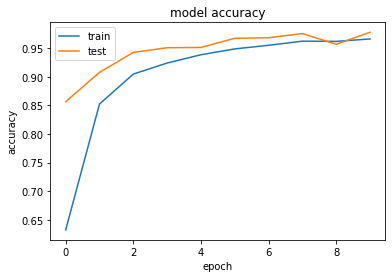

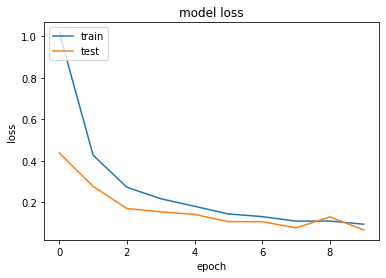

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cnn_model.history['acc'])
plt.plot(cnn_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Recurrent Neural Network

In [11]:
def rnn_model():
    model=Sequential()
    model.add(LSTM(128,return_sequences=True, input_shape=input_data))
    model.add(LSTM(128,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation='relu')))
    model.add(TimeDistributed(Dense(32,activation='relu')))
    model.add(TimeDistributed(Dense(16,activation='relu')))
    model.add(TimeDistributed(Dense(8,activation='relu')))
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [12]:
config=Config(mode='time')
print(config.mode)

time


In [ ]:
if config.mode == 'conv' :
    X,y=process()
    y_index_max=np.argmax(y,axis=1)
    input_data=(X.shape[1], X.shape[2], 1)
    model=cnn_model()

elif config.mode== 'time':
    X,y= process()
    y_index_max=np.argmax(y,axis=1)
    input_data=(X.shape[1], X.shape[2])
    model=rnn_model()

    
class_weight= compute_class_weight('balanced',np.unique(y_index_max),y_index_max)

checkpoint=ModelCheckpoint(config.model_path,monitor='val_acc',verbose=1,mode='max',save_best_only=True,save_weights_only=False,period=1)
rnn_model=model.fit(X,y,epochs=10,batch_size=32,shuffle=True,validation_split=0.1,callbacks=[checkpoint])

model.save(config.model_path)

loading the existing data for time model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_4 (TimeDist (None,

12640/19627 [==================>...........] - ETA: 25:20 - loss: 2.3030 - acc: 0.06 - ETA: 8:39 - loss: 2.2993 - acc: 0.0729 - ETA: 5:18 - loss: 2.2960 - acc: 0.081 - ETA: 4:32 - loss: 2.2957 - acc: 0.093 - ETA: 4:00 - loss: 2.2966 - acc: 0.089 - ETA: 3:35 - loss: 2.2918 - acc: 0.093 - ETA: 2:56 - loss: 2.2866 - acc: 0.096 - ETA: 2:29 - loss: 2.2831 - acc: 0.093 - ETA: 2:10 - loss: 2.2776 - acc: 0.100 - ETA: 1:56 - loss: 2.2776 - acc: 0.105 - ETA: 1:45 - loss: 2.2742 - acc: 0.109 - ETA: 1:36 - loss: 2.2725 - acc: 0.109 - ETA: 1:28 - loss: 2.2717 - acc: 0.106 - ETA: 1:22 - loss: 2.2706 - acc: 0.106 - ETA: 1:17 - loss: 2.2659 - acc: 0.109 - ETA: 1:13 - loss: 2.2612 - acc: 0.110 - ETA: 1:09 - loss: 2.2512 - acc: 0.113 - ETA: 1:05 - loss: 2.2500 - acc: 0.113 - ETA: 1:02 - loss: 2.2530 - acc: 0.114 - ETA: 1:00 - loss: 2.2497 - acc: 0.118 - ETA: 57s - loss: 2.2455 - acc: 0.122 - ETA: 55s - loss: 2.2435 - acc: 0.12 - ETA: 53s - loss: 2.2417 - acc: 0.12 - ETA: 51s - loss: 2.2395 - acc: 0.13 -

19627/19627 [==============================] - ETA: 9s - loss: 1.9012 - acc: 0.2780 - ETA: 9s - loss: 1.8992 - acc: 0.279 - ETA: 9s - loss: 1.8974 - acc: 0.280 - ETA: 9s - loss: 1.8958 - acc: 0.280 - ETA: 9s - loss: 1.8942 - acc: 0.281 - ETA: 9s - loss: 1.8919 - acc: 0.282 - ETA: 9s - loss: 1.8901 - acc: 0.283 - ETA: 9s - loss: 1.8888 - acc: 0.283 - ETA: 9s - loss: 1.8865 - acc: 0.284 - ETA: 8s - loss: 1.8847 - acc: 0.285 - ETA: 8s - loss: 1.8833 - acc: 0.286 - ETA: 8s - loss: 1.8809 - acc: 0.288 - ETA: 8s - loss: 1.8784 - acc: 0.289 - ETA: 8s - loss: 1.8774 - acc: 0.289 - ETA: 8s - loss: 1.8778 - acc: 0.289 - ETA: 8s - loss: 1.8759 - acc: 0.290 - ETA: 8s - loss: 1.8737 - acc: 0.291 - ETA: 8s - loss: 1.8720 - acc: 0.292 - ETA: 8s - loss: 1.8703 - acc: 0.292 - ETA: 8s - loss: 1.8693 - acc: 0.293 - ETA: 8s - loss: 1.8684 - acc: 0.293 - ETA: 7s - loss: 1.8671 - acc: 0.294 - ETA: 7s - loss: 1.8661 - acc: 0.294 - ETA: 7s - loss: 1.8648 - acc: 0.295 - ETA: 7s - loss: 1.8632 - acc: 0.296 - ET

11456/19627 [================>.............] - ETA: 21s - loss: 1.7103 - acc: 0.37 - ETA: 21s - loss: 1.3555 - acc: 0.50 - ETA: 20s - loss: 1.2397 - acc: 0.54 - ETA: 20s - loss: 1.2305 - acc: 0.54 - ETA: 20s - loss: 1.2395 - acc: 0.54 - ETA: 20s - loss: 1.2656 - acc: 0.52 - ETA: 20s - loss: 1.2932 - acc: 0.51 - ETA: 20s - loss: 1.2466 - acc: 0.53 - ETA: 20s - loss: 1.2588 - acc: 0.52 - ETA: 21s - loss: 1.2766 - acc: 0.51 - ETA: 21s - loss: 1.2730 - acc: 0.52 - ETA: 21s - loss: 1.2526 - acc: 0.52 - ETA: 24s - loss: 1.2541 - acc: 0.53 - ETA: 30s - loss: 1.2527 - acc: 0.53 - ETA: 32s - loss: 1.2622 - acc: 0.53 - ETA: 34s - loss: 1.2703 - acc: 0.52 - ETA: 34s - loss: 1.2648 - acc: 0.53 - ETA: 34s - loss: 1.2522 - acc: 0.53 - ETA: 35s - loss: 1.2454 - acc: 0.54 - ETA: 35s - loss: 1.2426 - acc: 0.54 - ETA: 35s - loss: 1.2425 - acc: 0.54 - ETA: 35s - loss: 1.2521 - acc: 0.53 - ETA: 35s - loss: 1.2604 - acc: 0.53 - ETA: 35s - loss: 1.2559 - acc: 0.53 - ETA: 36s - loss: 1.2610 - acc: 0.53 - ETA

19627/19627 [==============================] - ETA: 10s - loss: 1.1695 - acc: 0.57 - ETA: 10s - loss: 1.1690 - acc: 0.57 - ETA: 10s - loss: 1.1677 - acc: 0.57 - ETA: 10s - loss: 1.1673 - acc: 0.57 - ETA: 10s - loss: 1.1670 - acc: 0.57 - ETA: 10s - loss: 1.1670 - acc: 0.57 - ETA: 10s - loss: 1.1662 - acc: 0.57 - ETA: 10s - loss: 1.1642 - acc: 0.57 - ETA: 10s - loss: 1.1643 - acc: 0.57 - ETA: 9s - loss: 1.1637 - acc: 0.5793 - ETA: 9s - loss: 1.1636 - acc: 0.579 - ETA: 9s - loss: 1.1632 - acc: 0.579 - ETA: 9s - loss: 1.1629 - acc: 0.579 - ETA: 9s - loss: 1.1640 - acc: 0.579 - ETA: 9s - loss: 1.1628 - acc: 0.579 - ETA: 9s - loss: 1.1624 - acc: 0.579 - ETA: 9s - loss: 1.1624 - acc: 0.579 - ETA: 9s - loss: 1.1625 - acc: 0.579 - ETA: 9s - loss: 1.1638 - acc: 0.578 - ETA: 8s - loss: 1.1638 - acc: 0.578 - ETA: 8s - loss: 1.1631 - acc: 0.578 - ETA: 8s - loss: 1.1627 - acc: 0.579 - ETA: 8s - loss: 1.1626 - acc: 0.579 - ETA: 8s - loss: 1.1620 - acc: 0.579 - ETA: 8s - loss: 1.1608 - acc: 0.579 - ET

13600/19627 [===================>..........] - ETA: 22s - loss: 1.1499 - acc: 0.62 - ETA: 22s - loss: 0.9897 - acc: 0.66 - ETA: 21s - loss: 0.8834 - acc: 0.70 - ETA: 20s - loss: 0.8839 - acc: 0.69 - ETA: 19s - loss: 0.8513 - acc: 0.71 - ETA: 19s - loss: 0.8710 - acc: 0.70 - ETA: 19s - loss: 0.8525 - acc: 0.70 - ETA: 19s - loss: 0.8453 - acc: 0.70 - ETA: 19s - loss: 0.8479 - acc: 0.71 - ETA: 19s - loss: 0.8614 - acc: 0.71 - ETA: 18s - loss: 0.8834 - acc: 0.70 - ETA: 18s - loss: 0.8778 - acc: 0.70 - ETA: 18s - loss: 0.8849 - acc: 0.70 - ETA: 18s - loss: 0.9015 - acc: 0.69 - ETA: 18s - loss: 0.8967 - acc: 0.69 - ETA: 18s - loss: 0.8879 - acc: 0.69 - ETA: 18s - loss: 0.8890 - acc: 0.69 - ETA: 18s - loss: 0.9010 - acc: 0.68 - ETA: 18s - loss: 0.9017 - acc: 0.68 - ETA: 18s - loss: 0.8931 - acc: 0.68 - ETA: 18s - loss: 0.8965 - acc: 0.68 - ETA: 18s - loss: 0.8909 - acc: 0.68 - ETA: 18s - loss: 0.8935 - acc: 0.68 - ETA: 17s - loss: 0.8876 - acc: 0.69 - ETA: 17s - loss: 0.8831 - acc: 0.69 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.8360 - acc: 0.701 - ETA: 5s - loss: 0.8360 - acc: 0.702 - ETA: 5s - loss: 0.8356 - acc: 0.702 - ETA: 5s - loss: 0.8356 - acc: 0.702 - ETA: 5s - loss: 0.8345 - acc: 0.702 - ETA: 5s - loss: 0.8364 - acc: 0.702 - ETA: 5s - loss: 0.8365 - acc: 0.702 - ETA: 5s - loss: 0.8375 - acc: 0.702 - ETA: 5s - loss: 0.8378 - acc: 0.702 - ETA: 5s - loss: 0.8373 - acc: 0.702 - ETA: 5s - loss: 0.8358 - acc: 0.703 - ETA: 5s - loss: 0.8355 - acc: 0.703 - ETA: 5s - loss: 0.8345 - acc: 0.703 - ETA: 5s - loss: 0.8345 - acc: 0.703 - ETA: 5s - loss: 0.8343 - acc: 0.703 - ETA: 5s - loss: 0.8345 - acc: 0.703 - ETA: 4s - loss: 0.8340 - acc: 0.703 - ETA: 4s - loss: 0.8340 - acc: 0.703 - ETA: 4s - loss: 0.8337 - acc: 0.703 - ETA: 4s - loss: 0.8337 - acc: 0.703 - ETA: 4s - loss: 0.8332 - acc: 0.703 - ETA: 4s - loss: 0.8328 - acc: 0.704 - ETA: 4s - loss: 0.8326 - acc: 0.703 - ETA: 4s - loss: 0.8313 - acc: 0.704 - ETA: 4s - loss: 0.8303 - acc: 0.704 - ETA

13344/19627 [===================>..........] - ETA: 24s - loss: 0.5926 - acc: 0.81 - ETA: 21s - loss: 0.7881 - acc: 0.73 - ETA: 20s - loss: 0.7341 - acc: 0.75 - ETA: 19s - loss: 0.7827 - acc: 0.73 - ETA: 19s - loss: 0.7622 - acc: 0.74 - ETA: 19s - loss: 0.7659 - acc: 0.74 - ETA: 19s - loss: 0.7967 - acc: 0.73 - ETA: 18s - loss: 0.7554 - acc: 0.75 - ETA: 18s - loss: 0.7258 - acc: 0.75 - ETA: 18s - loss: 0.7175 - acc: 0.75 - ETA: 18s - loss: 0.7199 - acc: 0.75 - ETA: 18s - loss: 0.7054 - acc: 0.75 - ETA: 18s - loss: 0.6784 - acc: 0.76 - ETA: 17s - loss: 0.6825 - acc: 0.76 - ETA: 17s - loss: 0.6896 - acc: 0.76 - ETA: 17s - loss: 0.6941 - acc: 0.76 - ETA: 17s - loss: 0.6761 - acc: 0.76 - ETA: 17s - loss: 0.6716 - acc: 0.77 - ETA: 17s - loss: 0.6878 - acc: 0.76 - ETA: 17s - loss: 0.6804 - acc: 0.77 - ETA: 17s - loss: 0.6921 - acc: 0.76 - ETA: 17s - loss: 0.6870 - acc: 0.76 - ETA: 17s - loss: 0.6908 - acc: 0.76 - ETA: 17s - loss: 0.6889 - acc: 0.76 - ETA: 17s - loss: 0.6912 - acc: 0.76 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.6746 - acc: 0.767 - ETA: 6s - loss: 0.6755 - acc: 0.767 - ETA: 6s - loss: 0.6762 - acc: 0.767 - ETA: 6s - loss: 0.6776 - acc: 0.766 - ETA: 6s - loss: 0.6799 - acc: 0.766 - ETA: 6s - loss: 0.6796 - acc: 0.766 - ETA: 5s - loss: 0.6798 - acc: 0.766 - ETA: 5s - loss: 0.6807 - acc: 0.765 - ETA: 5s - loss: 0.6810 - acc: 0.765 - ETA: 5s - loss: 0.6809 - acc: 0.766 - ETA: 5s - loss: 0.6806 - acc: 0.766 - ETA: 5s - loss: 0.6799 - acc: 0.766 - ETA: 5s - loss: 0.6804 - acc: 0.766 - ETA: 5s - loss: 0.6803 - acc: 0.766 - ETA: 5s - loss: 0.6804 - acc: 0.766 - ETA: 5s - loss: 0.6802 - acc: 0.766 - ETA: 5s - loss: 0.6800 - acc: 0.766 - ETA: 5s - loss: 0.6794 - acc: 0.766 - ETA: 5s - loss: 0.6812 - acc: 0.766 - ETA: 5s - loss: 0.6812 - acc: 0.765 - ETA: 5s - loss: 0.6814 - acc: 0.765 - ETA: 4s - loss: 0.6806 - acc: 0.766 - ETA: 4s - loss: 0.6809 - acc: 0.766 - ETA: 4s - loss: 0.6820 - acc: 0.765 - ETA: 4s - loss: 0.6821 - acc: 0.765 - ETA

13600/19627 [===================>..........] - ETA: 22s - loss: 0.5181 - acc: 0.81 - ETA: 21s - loss: 0.5583 - acc: 0.80 - ETA: 21s - loss: 0.6329 - acc: 0.78 - ETA: 20s - loss: 0.5905 - acc: 0.79 - ETA: 20s - loss: 0.6026 - acc: 0.79 - ETA: 20s - loss: 0.6201 - acc: 0.78 - ETA: 19s - loss: 0.6317 - acc: 0.77 - ETA: 19s - loss: 0.6334 - acc: 0.78 - ETA: 20s - loss: 0.6358 - acc: 0.77 - ETA: 20s - loss: 0.6256 - acc: 0.77 - ETA: 19s - loss: 0.6315 - acc: 0.76 - ETA: 19s - loss: 0.6117 - acc: 0.77 - ETA: 19s - loss: 0.6198 - acc: 0.77 - ETA: 19s - loss: 0.6147 - acc: 0.78 - ETA: 19s - loss: 0.6219 - acc: 0.77 - ETA: 19s - loss: 0.6282 - acc: 0.77 - ETA: 19s - loss: 0.6344 - acc: 0.76 - ETA: 19s - loss: 0.6344 - acc: 0.77 - ETA: 18s - loss: 0.6413 - acc: 0.77 - ETA: 18s - loss: 0.6424 - acc: 0.77 - ETA: 18s - loss: 0.6461 - acc: 0.76 - ETA: 18s - loss: 0.6435 - acc: 0.76 - ETA: 18s - loss: 0.6416 - acc: 0.77 - ETA: 18s - loss: 0.6415 - acc: 0.77 - ETA: 18s - loss: 0.6430 - acc: 0.76 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.5657 - acc: 0.803 - ETA: 5s - loss: 0.5662 - acc: 0.803 - ETA: 5s - loss: 0.5662 - acc: 0.803 - ETA: 5s - loss: 0.5653 - acc: 0.803 - ETA: 5s - loss: 0.5647 - acc: 0.803 - ETA: 5s - loss: 0.5645 - acc: 0.804 - ETA: 5s - loss: 0.5645 - acc: 0.804 - ETA: 5s - loss: 0.5637 - acc: 0.804 - ETA: 5s - loss: 0.5632 - acc: 0.804 - ETA: 5s - loss: 0.5628 - acc: 0.804 - ETA: 5s - loss: 0.5621 - acc: 0.804 - ETA: 5s - loss: 0.5609 - acc: 0.805 - ETA: 5s - loss: 0.5607 - acc: 0.805 - ETA: 5s - loss: 0.5614 - acc: 0.804 - ETA: 5s - loss: 0.5613 - acc: 0.805 - ETA: 5s - loss: 0.5611 - acc: 0.805 - ETA: 4s - loss: 0.5611 - acc: 0.805 - ETA: 4s - loss: 0.5616 - acc: 0.804 - ETA: 4s - loss: 0.5611 - acc: 0.804 - ETA: 4s - loss: 0.5602 - acc: 0.805 - ETA: 4s - loss: 0.5596 - acc: 0.805 - ETA: 4s - loss: 0.5600 - acc: 0.805 - ETA: 4s - loss: 0.5596 - acc: 0.805 - ETA: 4s - loss: 0.5593 - acc: 0.805 - ETA: 4s - loss: 0.5591 - acc: 0.805 - ETA

13632/19627 [===================>..........] - ETA: 22s - loss: 0.2204 - acc: 0.93 - ETA: 24s - loss: 0.5947 - acc: 0.85 - ETA: 23s - loss: 0.6409 - acc: 0.82 - ETA: 21s - loss: 0.5986 - acc: 0.82 - ETA: 21s - loss: 0.5478 - acc: 0.83 - ETA: 20s - loss: 0.5543 - acc: 0.83 - ETA: 20s - loss: 0.5565 - acc: 0.82 - ETA: 20s - loss: 0.5762 - acc: 0.81 - ETA: 20s - loss: 0.5787 - acc: 0.80 - ETA: 20s - loss: 0.5689 - acc: 0.81 - ETA: 20s - loss: 0.5742 - acc: 0.81 - ETA: 20s - loss: 0.5902 - acc: 0.80 - ETA: 20s - loss: 0.5760 - acc: 0.80 - ETA: 20s - loss: 0.5703 - acc: 0.81 - ETA: 21s - loss: 0.5740 - acc: 0.81 - ETA: 21s - loss: 0.5731 - acc: 0.80 - ETA: 21s - loss: 0.5648 - acc: 0.81 - ETA: 20s - loss: 0.5667 - acc: 0.81 - ETA: 20s - loss: 0.5542 - acc: 0.82 - ETA: 20s - loss: 0.5425 - acc: 0.82 - ETA: 20s - loss: 0.5373 - acc: 0.82 - ETA: 20s - loss: 0.5285 - acc: 0.82 - ETA: 20s - loss: 0.5352 - acc: 0.82 - ETA: 19s - loss: 0.5261 - acc: 0.82 - ETA: 19s - loss: 0.5255 - acc: 0.82 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.4757 - acc: 0.840 - ETA: 5s - loss: 0.4755 - acc: 0.840 - ETA: 5s - loss: 0.4765 - acc: 0.840 - ETA: 5s - loss: 0.4757 - acc: 0.840 - ETA: 5s - loss: 0.4750 - acc: 0.841 - ETA: 5s - loss: 0.4749 - acc: 0.841 - ETA: 5s - loss: 0.4740 - acc: 0.841 - ETA: 5s - loss: 0.4738 - acc: 0.841 - ETA: 5s - loss: 0.4733 - acc: 0.841 - ETA: 5s - loss: 0.4730 - acc: 0.841 - ETA: 5s - loss: 0.4732 - acc: 0.841 - ETA: 5s - loss: 0.4726 - acc: 0.841 - ETA: 5s - loss: 0.4740 - acc: 0.841 - ETA: 5s - loss: 0.4737 - acc: 0.841 - ETA: 5s - loss: 0.4747 - acc: 0.841 - ETA: 5s - loss: 0.4747 - acc: 0.840 - ETA: 5s - loss: 0.4751 - acc: 0.840 - ETA: 4s - loss: 0.4745 - acc: 0.841 - ETA: 4s - loss: 0.4751 - acc: 0.840 - ETA: 4s - loss: 0.4755 - acc: 0.840 - ETA: 4s - loss: 0.4747 - acc: 0.840 - ETA: 4s - loss: 0.4739 - acc: 0.841 - ETA: 4s - loss: 0.4739 - acc: 0.841 - ETA: 4s - loss: 0.4739 - acc: 0.840 - ETA: 4s - loss: 0.4734 - acc: 0.840 - ETA

13568/19627 [===================>..........] - ETA: 24s - loss: 0.2055 - acc: 0.93 - ETA: 22s - loss: 0.2172 - acc: 0.93 - ETA: 21s - loss: 0.2442 - acc: 0.91 - ETA: 21s - loss: 0.3114 - acc: 0.89 - ETA: 20s - loss: 0.3706 - acc: 0.86 - ETA: 20s - loss: 0.3636 - acc: 0.87 - ETA: 20s - loss: 0.3748 - acc: 0.87 - ETA: 21s - loss: 0.3724 - acc: 0.87 - ETA: 21s - loss: 0.3896 - acc: 0.86 - ETA: 20s - loss: 0.3975 - acc: 0.86 - ETA: 20s - loss: 0.4097 - acc: 0.85 - ETA: 20s - loss: 0.4179 - acc: 0.85 - ETA: 20s - loss: 0.4105 - acc: 0.85 - ETA: 20s - loss: 0.4227 - acc: 0.85 - ETA: 20s - loss: 0.4125 - acc: 0.85 - ETA: 20s - loss: 0.4118 - acc: 0.85 - ETA: 19s - loss: 0.4182 - acc: 0.85 - ETA: 19s - loss: 0.4194 - acc: 0.85 - ETA: 19s - loss: 0.4207 - acc: 0.85 - ETA: 19s - loss: 0.4174 - acc: 0.85 - ETA: 19s - loss: 0.4171 - acc: 0.85 - ETA: 19s - loss: 0.4159 - acc: 0.85 - ETA: 18s - loss: 0.4188 - acc: 0.85 - ETA: 18s - loss: 0.4138 - acc: 0.85 - ETA: 18s - loss: 0.4087 - acc: 0.85 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.4179 - acc: 0.857 - ETA: 6s - loss: 0.4174 - acc: 0.858 - ETA: 6s - loss: 0.4175 - acc: 0.858 - ETA: 6s - loss: 0.4169 - acc: 0.858 - ETA: 6s - loss: 0.4167 - acc: 0.858 - ETA: 6s - loss: 0.4165 - acc: 0.858 - ETA: 5s - loss: 0.4159 - acc: 0.858 - ETA: 5s - loss: 0.4153 - acc: 0.859 - ETA: 5s - loss: 0.4152 - acc: 0.859 - ETA: 5s - loss: 0.4149 - acc: 0.859 - ETA: 5s - loss: 0.4144 - acc: 0.859 - ETA: 5s - loss: 0.4146 - acc: 0.859 - ETA: 5s - loss: 0.4140 - acc: 0.859 - ETA: 5s - loss: 0.4154 - acc: 0.859 - ETA: 5s - loss: 0.4159 - acc: 0.859 - ETA: 5s - loss: 0.4162 - acc: 0.858 - ETA: 5s - loss: 0.4153 - acc: 0.859 - ETA: 5s - loss: 0.4150 - acc: 0.859 - ETA: 5s - loss: 0.4149 - acc: 0.859 - ETA: 5s - loss: 0.4147 - acc: 0.859 - ETA: 4s - loss: 0.4162 - acc: 0.859 - ETA: 4s - loss: 0.4165 - acc: 0.858 - ETA: 4s - loss: 0.4170 - acc: 0.858 - ETA: 4s - loss: 0.4162 - acc: 0.859 - ETA: 4s - loss: 0.4165 - acc: 0.859 - ETA

13408/19627 [===================>..........] - ETA: 20s - loss: 0.2534 - acc: 0.96 - ETA: 21s - loss: 0.4140 - acc: 0.88 - ETA: 21s - loss: 0.4361 - acc: 0.85 - ETA: 21s - loss: 0.4031 - acc: 0.86 - ETA: 20s - loss: 0.4368 - acc: 0.85 - ETA: 20s - loss: 0.4220 - acc: 0.85 - ETA: 22s - loss: 0.4001 - acc: 0.86 - ETA: 21s - loss: 0.3996 - acc: 0.86 - ETA: 22s - loss: 0.4032 - acc: 0.86 - ETA: 23s - loss: 0.4155 - acc: 0.86 - ETA: 23s - loss: 0.3952 - acc: 0.87 - ETA: 23s - loss: 0.4011 - acc: 0.86 - ETA: 22s - loss: 0.4087 - acc: 0.86 - ETA: 22s - loss: 0.4059 - acc: 0.86 - ETA: 22s - loss: 0.3954 - acc: 0.87 - ETA: 22s - loss: 0.3941 - acc: 0.87 - ETA: 21s - loss: 0.3782 - acc: 0.87 - ETA: 21s - loss: 0.3681 - acc: 0.88 - ETA: 21s - loss: 0.3664 - acc: 0.88 - ETA: 21s - loss: 0.3656 - acc: 0.88 - ETA: 20s - loss: 0.3665 - acc: 0.88 - ETA: 20s - loss: 0.3722 - acc: 0.87 - ETA: 20s - loss: 0.3691 - acc: 0.87 - ETA: 20s - loss: 0.3740 - acc: 0.87 - ETA: 20s - loss: 0.3803 - acc: 0.87 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.3697 - acc: 0.873 - ETA: 6s - loss: 0.3697 - acc: 0.873 - ETA: 6s - loss: 0.3693 - acc: 0.873 - ETA: 5s - loss: 0.3694 - acc: 0.873 - ETA: 5s - loss: 0.3686 - acc: 0.873 - ETA: 5s - loss: 0.3689 - acc: 0.873 - ETA: 5s - loss: 0.3690 - acc: 0.873 - ETA: 5s - loss: 0.3689 - acc: 0.873 - ETA: 5s - loss: 0.3694 - acc: 0.873 - ETA: 5s - loss: 0.3693 - acc: 0.873 - ETA: 5s - loss: 0.3694 - acc: 0.873 - ETA: 5s - loss: 0.3697 - acc: 0.873 - ETA: 5s - loss: 0.3696 - acc: 0.873 - ETA: 5s - loss: 0.3691 - acc: 0.873 - ETA: 5s - loss: 0.3701 - acc: 0.873 - ETA: 5s - loss: 0.3699 - acc: 0.873 - ETA: 5s - loss: 0.3711 - acc: 0.873 - ETA: 5s - loss: 0.3724 - acc: 0.873 - ETA: 4s - loss: 0.3729 - acc: 0.872 - ETA: 4s - loss: 0.3738 - acc: 0.872 - ETA: 4s - loss: 0.3745 - acc: 0.872 - ETA: 4s - loss: 0.3751 - acc: 0.872 - ETA: 4s - loss: 0.3751 - acc: 0.872 - ETA: 4s - loss: 0.3754 - acc: 0.871 - ETA: 4s - loss: 0.3768 - acc: 0.871 - ETA

13216/19627 [===================>..........] - ETA: 21s - loss: 0.2164 - acc: 0.90 - ETA: 22s - loss: 0.3418 - acc: 0.85 - ETA: 22s - loss: 0.3876 - acc: 0.83 - ETA: 21s - loss: 0.3798 - acc: 0.85 - ETA: 21s - loss: 0.3511 - acc: 0.87 - ETA: 20s - loss: 0.3494 - acc: 0.86 - ETA: 21s - loss: 0.3532 - acc: 0.86 - ETA: 21s - loss: 0.3461 - acc: 0.87 - ETA: 21s - loss: 0.3770 - acc: 0.85 - ETA: 20s - loss: 0.3737 - acc: 0.86 - ETA: 20s - loss: 0.3692 - acc: 0.86 - ETA: 20s - loss: 0.3828 - acc: 0.86 - ETA: 20s - loss: 0.3796 - acc: 0.86 - ETA: 20s - loss: 0.3690 - acc: 0.86 - ETA: 20s - loss: 0.3710 - acc: 0.86 - ETA: 20s - loss: 0.3727 - acc: 0.86 - ETA: 20s - loss: 0.3714 - acc: 0.86 - ETA: 19s - loss: 0.3703 - acc: 0.87 - ETA: 19s - loss: 0.3745 - acc: 0.86 - ETA: 19s - loss: 0.3686 - acc: 0.87 - ETA: 19s - loss: 0.3664 - acc: 0.87 - ETA: 19s - loss: 0.3616 - acc: 0.87 - ETA: 19s - loss: 0.3614 - acc: 0.87 - ETA: 20s - loss: 0.3637 - acc: 0.87 - ETA: 20s - loss: 0.3586 - acc: 0.87 - ETA

19627/19627 [==============================] - ETA: 6s - loss: 0.3429 - acc: 0.885 - ETA: 6s - loss: 0.3431 - acc: 0.885 - ETA: 6s - loss: 0.3421 - acc: 0.886 - ETA: 6s - loss: 0.3422 - acc: 0.886 - ETA: 6s - loss: 0.3422 - acc: 0.886 - ETA: 6s - loss: 0.3424 - acc: 0.885 - ETA: 6s - loss: 0.3429 - acc: 0.885 - ETA: 6s - loss: 0.3427 - acc: 0.886 - ETA: 5s - loss: 0.3431 - acc: 0.885 - ETA: 5s - loss: 0.3429 - acc: 0.886 - ETA: 5s - loss: 0.3427 - acc: 0.885 - ETA: 5s - loss: 0.3420 - acc: 0.886 - ETA: 5s - loss: 0.3421 - acc: 0.886 - ETA: 5s - loss: 0.3413 - acc: 0.886 - ETA: 5s - loss: 0.3414 - acc: 0.886 - ETA: 5s - loss: 0.3417 - acc: 0.886 - ETA: 5s - loss: 0.3413 - acc: 0.886 - ETA: 5s - loss: 0.3403 - acc: 0.886 - ETA: 5s - loss: 0.3399 - acc: 0.886 - ETA: 5s - loss: 0.3396 - acc: 0.887 - ETA: 5s - loss: 0.3406 - acc: 0.886 - ETA: 5s - loss: 0.3408 - acc: 0.886 - ETA: 5s - loss: 0.3414 - acc: 0.886 - ETA: 4s - loss: 0.3418 - acc: 0.886 - ETA: 4s - loss: 0.3416 - acc: 0.886 - ETA

13664/19627 [===================>..........] - ETA: 17s - loss: 0.0801 - acc: 0.96 - ETA: 17s - loss: 0.3098 - acc: 0.90 - ETA: 17s - loss: 0.2489 - acc: 0.93 - ETA: 17s - loss: 0.2458 - acc: 0.92 - ETA: 17s - loss: 0.2349 - acc: 0.92 - ETA: 17s - loss: 0.2711 - acc: 0.91 - ETA: 17s - loss: 0.3009 - acc: 0.90 - ETA: 17s - loss: 0.3203 - acc: 0.89 - ETA: 17s - loss: 0.3255 - acc: 0.89 - ETA: 17s - loss: 0.3238 - acc: 0.89 - ETA: 17s - loss: 0.3196 - acc: 0.89 - ETA: 17s - loss: 0.3170 - acc: 0.89 - ETA: 17s - loss: 0.3006 - acc: 0.90 - ETA: 17s - loss: 0.2926 - acc: 0.90 - ETA: 17s - loss: 0.2903 - acc: 0.90 - ETA: 17s - loss: 0.2867 - acc: 0.90 - ETA: 17s - loss: 0.3055 - acc: 0.90 - ETA: 17s - loss: 0.3111 - acc: 0.89 - ETA: 17s - loss: 0.3184 - acc: 0.89 - ETA: 17s - loss: 0.3308 - acc: 0.89 - ETA: 17s - loss: 0.3360 - acc: 0.89 - ETA: 17s - loss: 0.3362 - acc: 0.89 - ETA: 16s - loss: 0.3333 - acc: 0.88 - ETA: 16s - loss: 0.3473 - acc: 0.88 - ETA: 16s - loss: 0.3426 - acc: 0.88 - ETA

13728/19627 [===================>..........] - ETA: 5s - loss: 0.3262 - acc: 0.8910

### Graph Results of RNN

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(rnn_model.history['acc'])
plt.plot(rnn_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(rnn_model.history['loss'])
plt.plot(rnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()